# Testing
### Wohnflächenpreise (Median) der im Freihandkauf umgesetzten Wohnungen im Stockwerkeigentum nach Zimmerzahl seit 2009

Diese Daten beinhalten die Medianpreise pro Quadratmeter Wohnfläche von im Freihandkauf gehandelten Wohnungen im Stockwerkeigentum in der Stadt Zürich nach Handänderungsjahr und Zimmerzahl. Zusätzlich sind noch die absoluten Preise von im Freihandgekauf gehandelten Wohnungen im Stockwerkeigentum nach Zimmerzahl aufgeführt.

Datum: 07.02.2022

### Importiere die notwendigen Packages

In [7]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap

In [8]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [9]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [10]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [11]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=7, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=38, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [12]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_hae_preis_stwe_whg_zizahl_seit2009_od5152

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stwe_whg_zizahl_seit2009_od5152


In [13]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int";
print(status)

int


In [14]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_hae_preis_stwe_whg_zizahl_seit2009_od5152/download/BAU515OD5152.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_hae_preis_stwe_whg_zizahl_seit2009_od5152\BAU515OD5152.csv"   

print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_hae_preis_stwe_whg_zizahl_seit2009_od5152\BAU515OD5152.csv


In [15]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['Jahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [16]:
#data2betested.head(6)

In [17]:
data2betested.dtypes

Jahr              datetime64[ns]
Zimmerzahl                object
Zimmerzahl_S               int64
Medianqmp                  int64
Medianwhgpreis             int64
Anzahl_HAE                object
dtype: object

In [18]:
data2betested.shape

(101, 6)

Beschreibe einzelne Attribute

In [19]:
data2betested.describe()

,Zimmerzahl_S,Medianqmp,Medianwhgpreis
count,101,101,101
mean,4,11620,1783532
std,2,3051,1518527
min,1,5660,265000
25%,2,9310,825000
50%,4,11420,1362500
75%,6,12950,2142000
max,8,23540,9192950


Wie viele Nullwerte gibt es im Datensatz?

In [20]:
data2betested.isnull().sum()

Jahr              0
Zimmerzahl        0
Zimmerzahl_S      0
Medianqmp         0
Medianwhgpreis    0
Anzahl_HAE        0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [51]:
data2betested = data2betested.set_index("Jahr")

In [52]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101 entries, 2009-01-01 to 2021-01-01
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Zimmerzahl      101 non-null    object
 1   Zimmerzahl_S    101 non-null    int64 
 2   Medianqmp       101 non-null    int64 
 3   Medianwhgpreis  101 non-null    int64 
 4   Anzahl_HAE      101 non-null    object
dtypes: int64(3), object(2)
memory usage: 4.7+ KB


Int64Index([1], dtype='int64', name='Jahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [53]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [54]:
data2betested.loc["2021"].head(20)

,Zimmerzahl,Zimmerzahl_S,Medianqmp,Medianwhgpreis,Anzahl_HAE
Jahr,,,,,
2021-01-01,1-Zimmerwohnung,1,12160,610000,110
2021-01-01,2-Zimmerwohnung,2,13530,825000,99
2021-01-01,3-Zimmerwohnung,3,12650,1192000,284
2021-01-01,4-Zimmerwohnung,4,13450,1545000,243
2021-01-01,5-Zimmerwohnung,5,15340,2207500,74
2021-01-01,6-Zimmerwohnung,6,18550,2880000,7-9
2021-01-01,7-Zimmerwohnung,7,16440,5224640,1–3


### Visualisierungen nach Zeitausschnitten

#### Entwicklung der Medianquadratmeterwerte seit 2009

In [55]:
#data2betested.query('Quartier_Nummer == 33')

In [65]:
highlight = alt.selection(type='single', on='mouseover', fields=['Zimmerzahl'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(data2betested.reset_index().query('Anzahl_HAE != "1–3"'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('Medianqmp', axis=alt.Axis(title='Medianquadratmeterpreis'))
    , color=alt.Color('Zimmerzahl', legend=alt.Legend(title="Zimmerzahl", orient="right"))  
    ,tooltip=['Jahr', 'Zimmerzahl','Medianqmp','Medianwhgpreis','Anzahl_HAE']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung der Medianwohnungspreises nach Zimmerzahl seit 2009

In [66]:
data2betested.columns

Index(['Zimmerzahl', 'Zimmerzahl_S', 'Medianqmp', 'Medianwhgpreis', 'Anzahl_HAE'], dtype='object')

In [67]:
highlight = alt.selection(type='single', on='mouseover', fields=['Zimmerzahl'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(data2betested.reset_index().query('Anzahl_HAE != "1–3"'), title="Title").encode(
    x=alt.X('Jahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('Medianwhgpreis', axis=alt.Axis(title='Medianwohnungspreis'))
    , color=alt.Color('Zimmerzahl', legend=alt.Legend(title="Zimmerzahl", orient="right"))  
    ,tooltip=['Jahr', 'Zimmerzahl','Medianqmp','Medianwhgpreis','Anzahl_HAE']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [57]:
#help(sns.catplot)     

In [58]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

##### Medianquadratmeterpreise nach Zimmerzahl und Jahr

In [68]:
data2betested.dtypes

Zimmerzahl        object
Zimmerzahl_S       int64
Medianqmp          int64
Medianwhgpreis     int64
Anzahl_HAE        object
dtype: object

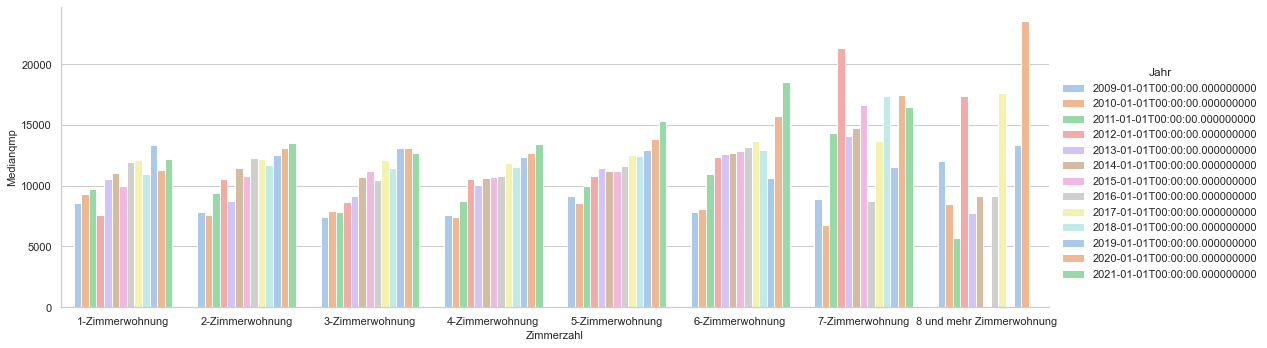

In [64]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(data=data2betested.loc["2009":"2021"].reset_index().query('Zimmerzahl_S > 0')
                     , x="Zimmerzahl"
            , y="Medianqmp"
            , hue="Jahr"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=3
            , order=None, legend_out=True
           )
myHist.set_xlabels('Zimmerzahl', fontsize=11) # not set_label
myHist.set_ylabels('Medianqmp', fontsize=11)


In [61]:
data2betested.dtypes

Zimmerzahl        object
Zimmerzahl_S       int64
Medianqmp          int64
Medianwhgpreis     int64
Anzahl_HAE        object
dtype: object

##### Entwicklung aller Freihandkäufe nach Hauptgrundstücktyp seit 2009

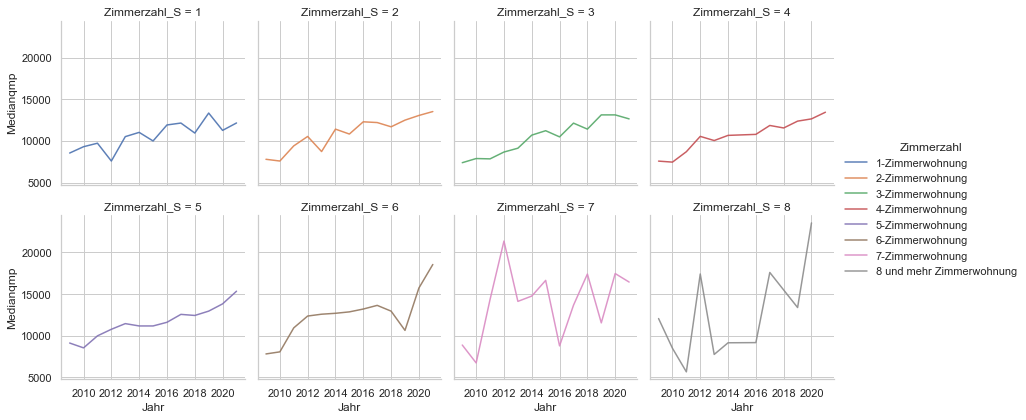

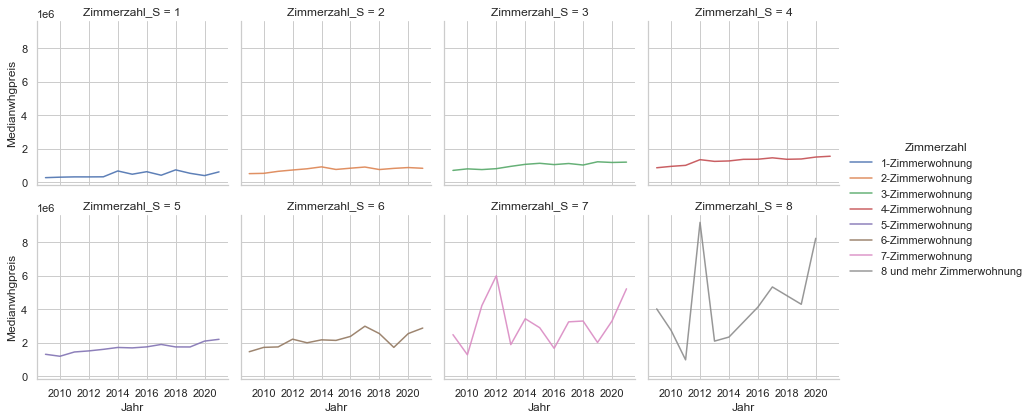

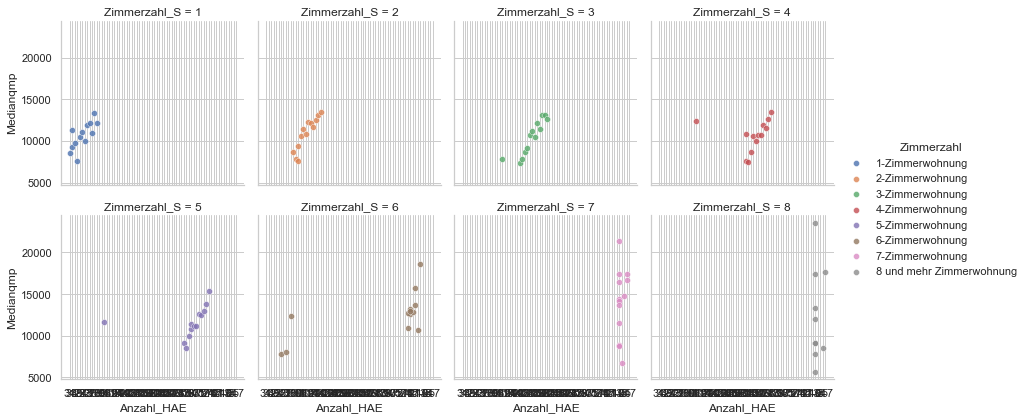

In [77]:
g = sns.FacetGrid(data=data2betested.loc["2009":"2021"].query('Medianwhgpreis > 20').reset_index(), col="Zimmerzahl_S", hue="Zimmerzahl", col_wrap=4, height=3)
#g.map(sns.scatterplot, "Jahr", "Medianqmp", alpha=.8)
g.map(sns.lineplot, "Jahr","Medianqmp", alpha=.9)
g.add_legend()


g2 = sns.FacetGrid(data=data2betested.loc["2009":"2021"].query('Medianwhgpreis > 20').reset_index(), col="Zimmerzahl_S", hue="Zimmerzahl", col_wrap=4, height=3)
#g.map(sns.scatterplot, "Jahr", "Medianqmp", alpha=.8)
g2.map(sns.lineplot, "Jahr","Medianwhgpreis", alpha=.9)
g2.add_legend()

g3 = sns.FacetGrid(data=data2betested.loc["2009":"2021"].query('Medianwhgpreis > 20').reset_index(), col="Zimmerzahl_S", hue="Zimmerzahl", col_wrap=4, height=3)
g3.map(sns.scatterplot, "Anzahl_HAE", "Medianqmp", alpha=.8)
#g3.map(sns.lineplot, "Jahr","Medianwhgpreis", alpha=.9)
g3.add_legend()


### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Medianquadratmeterpreis nach Zimmerzahl 2021 (Macht hier keinen SINN... Weil nicht aggregierbar)

In [90]:
myTreemap = data2betested.loc["2019":"2021"]\
    .groupby(['Jahr', 'Zimmerzahl', 'Zimmerzahl_S', 'Medianqmp','Medianwhgpreis','Anzahl_HAE' ]) \
    .agg(to_delete_Medianqmp=('Medianqmp', 'mean')) \
    .sort_values('Jahr', ascending=False) 

#myTreemap.reset_index().head(2)

In [91]:
#data2betested.dtypes

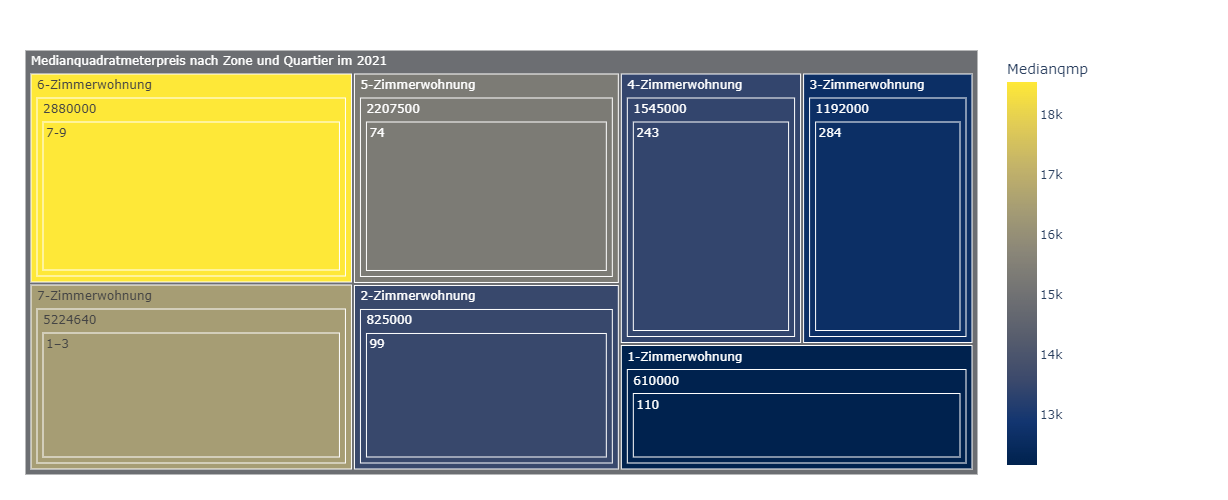

In [92]:
fig = px.treemap(data2betested.loc["2021"].query('Medianqmp > 0').reset_index()
                 , path=[px.Constant("Medianquadratmeterpreis nach Zone und Quartier im 2021")
                         ,'Zimmerzahl', 'Medianwhgpreis','Anzahl_HAE']
                 , values='Medianqmp'
                 , color='Medianqmp'               
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                 ,color_continuous_scale='cividis'
                 ,height=500 , width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [93]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=507&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [44]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [45]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [46]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [47]:
m = leafmap.Map()


#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [38]:
data2betested.dtypes

Quartier_Name      object
Quartier_Nummer     int64
Medianqmp           int64
Zonenart           object
Anzahl_HAE         object
dtype: object

In [ ]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


In [40]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [ ]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)

In [ ]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

In [ ]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=507&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**